R#2: it would be interesting to see the comparison with heavy-tailed bandit algorithms -- clipped estimators and median of means estimator. I do not think the empirical results demonstrated are very convincing.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.UCB_discrete import M_UCB, UCB1, UCB_V, MV_LCB, Exp3, Median_of_Means_UCB
from codes.Environment import Log_normal, AbsGau, Exp, setup_env
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

In [3]:
# setting

num_exper = 100
num_rounds = 1000
num_arms = 3

# environment


environments = [
    #{AbsGau: [0.5, 0.1], Exp: [1]},
    {Log_normal: [[0, 0.5], [1,0.5], [2,0.5]]}
]
paras = [50] # [rho for MV]
rewards_env, medians, means, mvs, samples = setup_env(num_arms, environments, paras)

In [4]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C'
}

for key in medians.keys():
    print(key)
    medians[key] = list(np.around(np.array(medians[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    mvs[key] = list(np.around(np.array(mvs[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row(['Median'] + medians[key]+ [arm_name_dict[np.argmax(medians[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    t.add_row(['MV']+ mvs[key]+ [arm_name_dict[np.argmin(mvs[key])]])
    print(t)
    print()

Log_normal_[[0, 0.5], [1, 0.5], [2, 0.5]]
+--------+--------+--------+---------+----------+
|  Eva   |   A    |   B    |    C    | Best Arm |
+--------+--------+--------+---------+----------+
| Median |  1.0   |  2.72  |   7.42  |    C     |
|  Mean  |  1.13  |  3.07  |   8.34  |    C     |
|   MV   | -56.14 | -150.7 | -398.09 |    C     |
+--------+--------+--------+---------+----------+



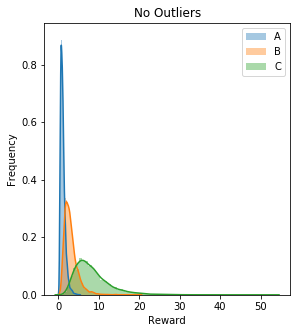

In [5]:
plot_hist(samples)

In [6]:
# run experiments

def run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname]= simulate(rewards_env[key],summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)
                
def run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for est_flag in est_flags:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds)
            
            # setting different parameters to with and without outliers groups
            if 'Outlier' in name:
                hyperpara = hyperpara_list[-1]
            else:
                hyperpara = hyperpara_list[0]
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'

            subname = policy_name + str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname]= simulate(rewards_env[key], summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)

In [7]:
results = defaultdict(dict)

# M-UCB

hyperpara_list = [[0.6, 0.2, 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians)

Log_normal_[[0, 0.5], [1, 0.5], [2, 0.5]]_100_1000M_UCB-[0.6, 0.2, 1]


IntProgress(value=0, description='Running')

/home/mengyan/git/eheye/UCB/M_UCB/codes/Environment.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/(x * self.sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - self.mu) ** 2/(2 * self.sigma ** 2))
/home/mengyan/git/eheye/UCB/M_UCB/codes/Environment.py:29: RuntimeWarning: divide by zero encountered in log
  return 1.0/(x * self.sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - self.mu) ** 2/(2 * self.sigma ** 2))
/home/mengyan/git/eheye/UCB/M_UCB/codes/Environment.py:29: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0/(x * self.sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - self.mu) ** 2/(2 * self.sigma ** 2))
/home/mengyan/git/eheye/UCB/M_UCB/codes/Environment.py:32: RuntimeWarning: divide by zero encountered in log
  return 0.5 + 0.5 * erf((np.log(x) - self.mu)/(np.sqrt(2) * self.sigma))


In [8]:
# Medain_of_means_UCB

hyperpara_list = [[10, 1, 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, Median_of_Means_UCB, means)


Log_normal_[[0, 0.5], [1, 0.5], [2, 0.5]]_100_1000Median_of_Means_UCB-[10, 1, 1]


IntProgress(value=0, description='Running')

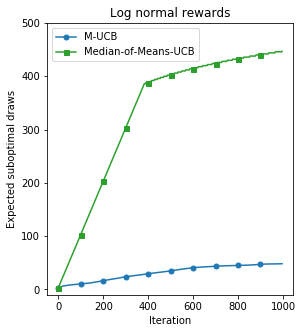

In [9]:
plot_eva(results, 'sd')

In [10]:
import pickle

with open('heavy_tails.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)